# Loading and Wrangling Data

Loading in data using the functions that we made:

In [3]:
oneBatch = True

In [4]:
# Run if you want one batch
import data_loading as dt
import os


if oneBatch:
    batchNum = 1
    if os.path.exists(f'batch{batchNum}/part_{batchNum}/'):
        ids, images = dt.importImages(f'batch{batchNum}/part_{batchNum}/')
    else:
        ids, images = dt.loadImageBatch(batchNum)
else:
    batchNums = list(range(1,13))
    ids, images = dt.loadImageBatches(batchNums)

Getting annotations and getting them into the correct order:

In [5]:
import pandas as pd
annotations = pd.read_csv("data/annotations.csv")
annotations.head()

,position,image
0,standing,1
1,standing,2
2,standing,3
3,standing,4
4,standing,5


In [6]:
position_maps= {"standing": 0, 
                "takedown1": 1,
                "takedown2": 2,
                "open_guard1": 3,
                "open_guard2": 4,
                "half_guard1": 5,
                "half_guard2": 6,
                "closed_guard1": 7,
                "closed_guard2": 8,
                "5050_guard": 9,
                "mount1": 10,
                "mount2": 11,
                "back1": 12,
                "back2": 13,
                "turtle1": 14,
                "turtle2": 15,               
                "side_control1" : 16,
                "side_control2" : 17}


labels = []
for id in ids:
    labels.append(position_maps[annotations[annotations['image'] == id]['position'].reset_index(drop=True)[0]])

In [ ]:
labels[0:20]

Converting images to tensors:

In [7]:
import torch
import numpy as np

# Converting into torch tensors
for i, img in enumerate(images):
    images[i] = torch.from_numpy(np.array(img))

# Convolutional Neural Net

## Creating Neural Net

In [26]:
# Data argumentation
from torchvision import transforms
data_transforms = transforms.Compose([
        transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180))
])

# CNN
from torch import nn
import torchvision
# class my_net(nn.Modul]e):
    
#     ## Constructor commands
#     def __init__(self):
#         super(my_net, self).__init__()
        
#         ## Define architecture
#         self.conv_stack = nn.Sequential(
#             nn.Conv2d(3,8,3,1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
#             nn.Conv2d(8,16,2,1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
#             nn.Flatten(),
#             nn.Linear(3600, 200),
#             nn.ReLU(),
#             nn.Linear(200, 18)
#         )
    
#     ## Function to generate predictions
#     def forward(self, x):
#         scores = self.conv_stack(x)
#         return scores


# Transfer Learnin
regnet_weights = torchvision.models.RegNet_X_400MF_Weights.IMAGENET1K_V2
regnet_model = torchvision.models.regnet_x_400mf(weights = regnet_weights)
torch.manual_seed(7) # For reproduction purposes (should be minor since only the last layers are randomly intialized)

lrate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lrate)
# print(net)
for param in net.parameters():
    # print(param)
    param.requires_grad = False
# print(net)
regnet_model.classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features=400, out_features=18, bias=True))
# print(regnet_model.classifier[0].parameters())
for param in regnet_model.classifier[0].parameters():
    print(param)
    param.requires_grad = True

net = regnet_model

Parameter containing:
tensor([[ 3.4923e-03, -3.0120e-02,  1.5921e-02,  ..., -1.9505e-02,
         -2.0996e-03,  3.3701e-02],
        [ 1.1098e-05,  2.3215e-02,  2.8633e-02,  ...,  1.6767e-02,
         -3.5529e-02,  3.3584e-02],
        [ 1.0616e-02,  3.2056e-02, -4.7595e-02,  ...,  4.7228e-02,
         -1.9226e-03, -1.2700e-02],
        ...,
        [ 1.4529e-02,  2.1283e-02, -2.2148e-02,  ...,  4.8218e-02,
          1.7195e-02, -3.5741e-02],
        [-2.8373e-02, -4.7629e-02,  2.8995e-02,  ...,  8.5895e-04,
         -1.2259e-02,  2.2470e-02],
        [-8.0511e-03, -2.4243e-02,  3.1586e-02,  ..., -4.8393e-03,
         -2.9083e-02,  4.7473e-02]], requires_grad=True)
Parameter containing:
tensor([ 1.0246e-02, -1.1154e-02,  2.9575e-02, -2.9340e-02,  3.4560e-02,
        -4.4570e-02, -3.4269e-02, -1.0834e-03,  3.6994e-02,  2.9584e-02,
         2.2993e-02,  1.9866e-02, -1.8745e-02,  1.9368e-02,  1.8767e-02,
         4.5089e-02, -4.8918e-02,  2.4240e-05], requires_grad=True)


In [9]:
print(regnet_model.classifier)

Sequential(
  (0): Linear(in_features=1000, out_features=18, bias=True)
)


## Training Neural Net

Train-test split:

In [10]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    images, labels, test_size=0.25, random_state=42)

train_X = torch.from_numpy(train_X)
train_X = torch.movedim(train_X, source=3, destination=1)

test_X = torch.from_numpy(test_X)
test_X = torch.movedim(test_X, source=3, destination=1)

In [35]:
## Hyperparms
epochs = 100
lrate = 0.0001
bsize = 28

## For reproduction purposes 
torch.manual_seed(3)

## Cost Function
cost_fn = nn.CrossEntropyLoss()


## Make DataLoader
from torch.utils.data import DataLoader, TensorDataset
y_tensor = torch.Tensor(train_y)
train_loader = DataLoader(TensorDataset(train_X.type(torch.FloatTensor), 
                        y_tensor.type(torch.LongTensor)), batch_size=bsize)

## Re-run the training loop, notice the new data_transforms() command
track_cost = np.zeros(epochs)
cur_cost = 0.0

for epoch in range(epochs):
    cur_cost = 0.0
    correct = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        ## Transform the input data using our data augmentation strategies
        # inputs = data_transforms(inputs)
        
        inputs = data_transforms(inputs)
        
        ## Same as before
        optimizer.zero_grad()
        outputs = net(inputs)
        cost = cost_fn(nn.Softmax(dim=1)(outputs), labels)
        cost.backward()
        optimizer.step()
        cur_cost += cost.item()
    
    ## Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    print("epoch: ", epoch)
    print("cost: ", cur_cost)
#     print(f"Epoch: {epoch} Cost: {cur_cost}") ## Uncomment this if you want printed updates
    
    

epoch:  0
cost:  1858.142177581787
epoch:  1
cost:  1858.1804790496826
epoch:  2
cost:  1858.221694946289
epoch:  3
cost:  1858.2332963943481
epoch:  4
cost:  1858.2404322624207
epoch:  5
cost:  1858.223692893982
epoch:  6
cost:  1858.1622595787048
epoch:  7
cost:  1858.2460551261902
epoch:  8
cost:  1858.2516117095947
epoch:  9
cost:  1858.2397356033325
epoch:  10
cost:  1858.2679748535156
epoch:  11
cost:  1858.257052898407
epoch:  12
cost:  1858.1799263954163
epoch:  13
cost:  1858.2667717933655
epoch:  14
cost:  1858.269187927246
epoch:  15
cost:  1858.1792950630188
epoch:  16
cost:  1858.2607645988464
epoch:  17
cost:  1858.2717957496643
epoch:  18
cost:  1858.185393333435
epoch:  19
cost:  1858.2628083229065
epoch:  20
cost:  1858.2439193725586
epoch:  21
cost:  1858.2002782821655
epoch:  22
cost:  1858.220558166504
epoch:  23
cost:  1858.2556099891663
epoch:  24
cost:  1858.2846150398254
epoch:  25
cost:  1858.2148246765137
epoch:  26
cost:  1858.2697443962097
epoch:  27
cost:  

Calculating training accuracy:

In [36]:
## Initialize objects for counting correct/total 
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    for data in train_loader:
        # Current batch of data
        images, labels = data
        
        # pass each batch into the network
        outputs = net(images)
        
        # the class with the maximum score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        # add size of the current batch
        total += labels.size(0)
        
        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

## Calculate and print the proportion correct
print(f"Training Accuracy is {correct/total}")

Training Accuracy is 0.0026602819898909284


Calculating testing accuracy:

In [37]:

## Combine X and y tensors into a TensorDataset and DataLoader
test_loader = DataLoader(TensorDataset(test_X.type(torch.FloatTensor), 
                        torch.Tensor(test_y).type(torch.LongTensor)), batch_size=bsize)

## Initialize objects for counting correct/total 
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    for data in test_loader:
        # Current batch of data
        images, labels = data
        
        # pass each batch into the network
        outputs = net(images)
        
        # the class with the maximum score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        # add size of the current batch
        total += labels.size(0)
        
        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

## Calculate and print the proportion correct
print(f"Test Accuracy is {correct/total}")

Test Accuracy is 0.0007980845969672786


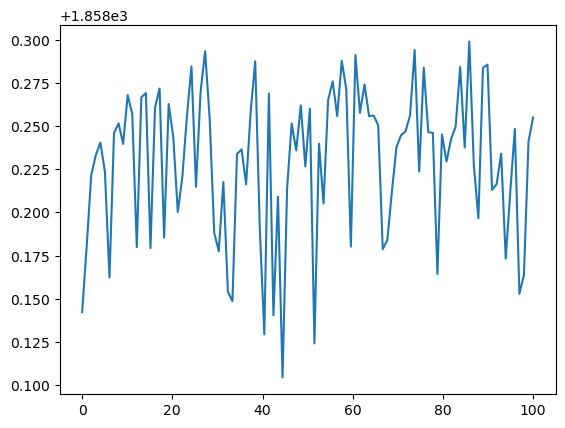

In [38]:
# verifying the convergence of cost
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.show()

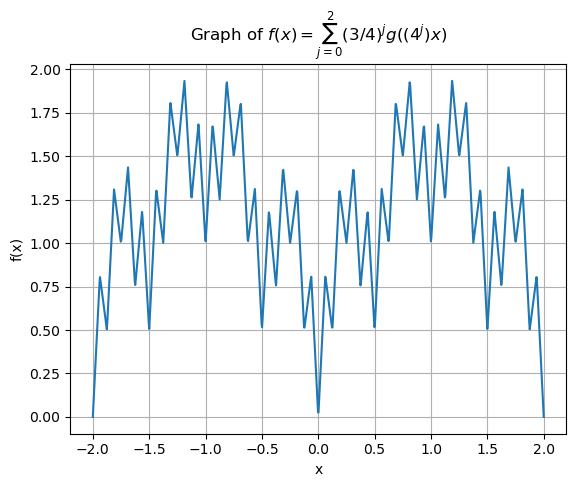

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def g(x):
    x = np.mod(x + 1, 2) - 1  # extend to the whole real line
    return np.abs(x)

x = np.linspace(-2, 2, 1000)
y = np.zeros_like(x)
for j in range(3):
    y += (3/4)**j * g((4**j)*x)

plt.plot(x, y)
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Graph of $f(x) = \sum_{j=0}^2 (3/4)^j g((4^j)x)$')
plt.show()


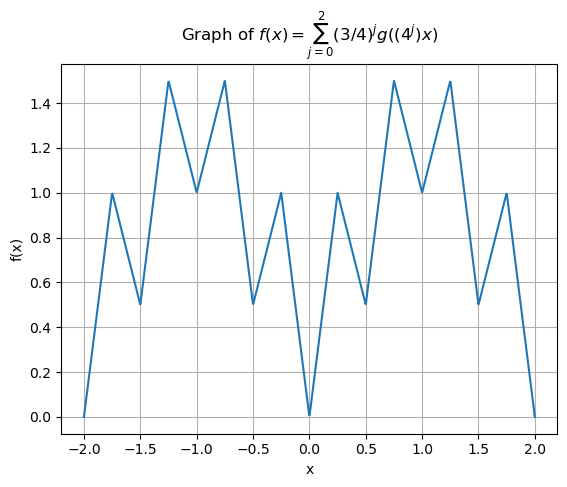

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def g(x):
    x = np.mod(x + 1, 2) - 1  # extend to the whole real line
    return np.abs(x)

x = np.linspace(-2, 2, 1000)
y = np.zeros_like(x)
for j in range(2):
    y += (3/4)**j * g((4**j)*x)

plt.plot(x, y)
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Graph of $f(x) = \sum_{j=0}^2 (3/4)^j g((4^j)x)$')
plt.show()


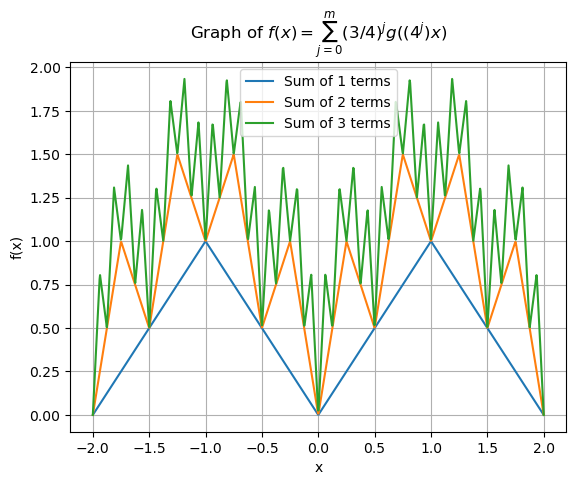

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def g(x):
    x = np.mod(x + 1, 2) - 1  # extend to the whole real line
    return np.abs(x)

x = np.linspace(-2, 2, 1000)
y0 = np.zeros_like(x)
y1 = np.zeros_like(x)
y2 = np.zeros_like(x)

for j in range(1):
    y0 += (3/4)**j * g((4**j)*x)

for j in range(2):
    y1 += (3/4)**j * g((4**j)*x)

for j in range(3):
    y2 += (3/4)**j * g((4**j)*x)

fig, ax = plt.subplots()
ax.plot(x, y0, label='Sum of 1 terms')
ax.plot(x, y1, label='Sum of 2 terms')
ax.plot(x, y2, label='Sum of 3 terms')
ax.grid()
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('Graph of $f(x) = \sum_{j=0}^m (3/4)^j g((4^j)x)$')

plt.show()


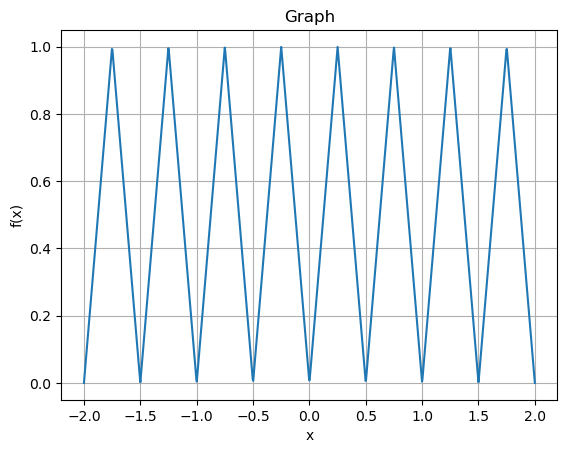

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def g(x):
    x = np.mod(x + 1, 2) - 1  # extend to the whole real line
    return np.abs(x)

x = np.linspace(-2, 2, 1000)
y = np.zeros_like(x)
a = 0
# for j in range(2):
y += g((4*x))


plt.plot(x, y)
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Graph')
plt.show()

# x = 1
# h1 = 1/2
# h2 = 1/8
# h3 = 1/32
# print((g((4**j)*(x+h1)) - g((4**j)*x)) / h1)
# print((g((4**j)*(x+h2)) - g((4**j)*x)) / h2)
# print((g((4**j)*(x+h3)) - g((4**j)*x)) / h3)




In [64]:
# print(y)
for i, e in enumerate(y):
    if abs(e - 1.75) < 0.1: 
        print(x[i])

-1.2672672672672673
-1.2632632632632632
-1.2592592592592593
-1.2552552552552552
-1.2512512512512513
-1.2472472472472473
-1.2432432432432432
-1.2392392392392393
-1.2352352352352352
-1.2312312312312312
-1.2272272272272273
-1.2232232232232232
-1.2192192192192193
-0.7827827827827827
-0.7787787787787788
-0.7747747747747749
-0.7707707707707707
-0.7667667667667668
-0.7627627627627627
-0.7587587587587588
-0.7547547547547548
-0.7507507507507507
-0.7467467467467468
-0.7427427427427427
-0.7387387387387387
-0.7347347347347348
-0.7307307307307307
0.7307307307307309
0.7347347347347348
0.7387387387387387
0.7427427427427427
0.7467467467467466
0.7507507507507509
0.7547547547547548
0.7587587587587588
0.7627627627627627
0.7667667667667666
0.7707707707707709
0.7747747747747749
0.7787787787787788
0.7827827827827827
1.219219219219219
1.2232232232232234
1.2272272272272273
1.2312312312312312
1.2352352352352352
1.239239239239239
1.2432432432432434
1.2472472472472473
1.2512512512512513
1.2552552552552552
1.2592

In [54]:
def g(x):
    x = np.mod(x + 1, 2) - 1  # extend to the whole real line
    return np.abs(x)

a = 0
y = 1.75

for x in np.linspace(-3, 3, 1000):
    fx = 0
    for j in range(3):
        fx += g((4**j)*x)
    if abs(fx - y) < 0.001:
        print('x =', x, 'produces f(x) =', fx)



x = -2.903903903903904 produces f(x) = 1.75075075075075
x = -1.0960960960960962 produces f(x) = 1.75075075075075
x = -0.9039039039039038 produces f(x) = 1.75075075075075
x = 0.9039039039039038 produces f(x) = 1.75075075075075
x = 1.0960960960960957 produces f(x) = 1.7507507507507558
x = 2.9039039039039043 produces f(x) = 1.7507507507507558


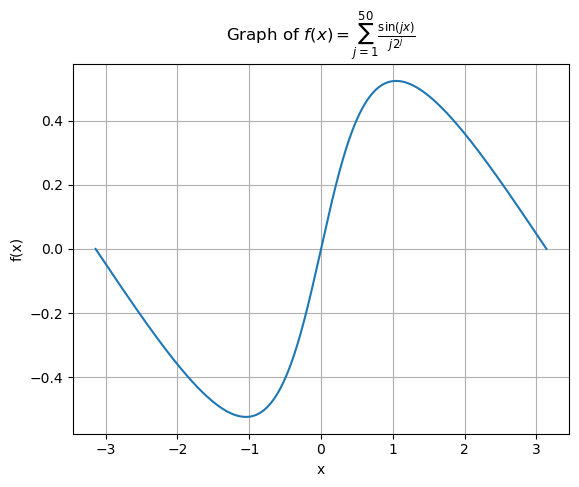

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    s = 0
    for j in range(1, 51):
        s += np.sin(j*x) / (j*2**j)
    return s

x = np.linspace(-np.pi, np.pi, 1000)
y = f(x)

plt.plot(x, y)
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Graph of $f(x) = \sum_{j=1}^{50} \\frac{\\sin(jx)}{j2^j}$')
plt.show()


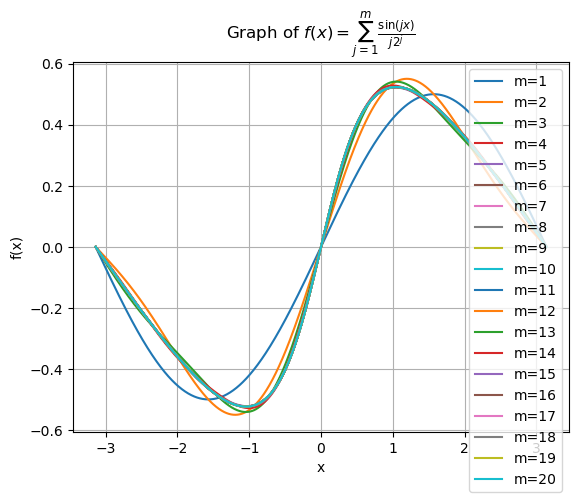

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, m):
    s = 0
    for j in range(1, m+1):
        s += np.sin(j*x) / (j*2**j)
    return s

x = np.linspace(-np.pi, np.pi, 1000)

for m in range(1, 21):
    y = f(x, m)
    plt.plot(x, y, label='m={}'.format(m))

plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Graph of $f(x) = \sum_{j=1}^{m} \\frac{\\sin(jx)}{j2^j}$')
plt.legend()
plt.show()
